<a href="https://colab.research.google.com/github/Nobel712/Deep-learning-project/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


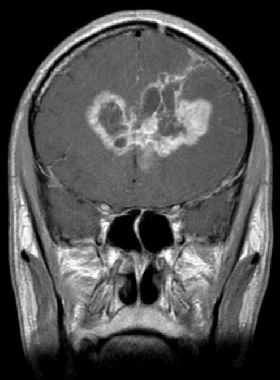

In [ ]:
fill='/content/drive/MyDrive/Deep Db/Testing/glioma_tumor/image(1).jpg'
from tensorflow.keras.preprocessing import image
img=image.load_img(fill,target_size=(380,280))
img

In [ ]:
def plot_images(direction):  
    list_direction=os.listdir(direction)

    plt.figure(figsize=(16,10))

    for i in range(1,10):
        plt.subplot(3,3,i)
        img=plt.imread(os.path.join(direction,list_direction[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

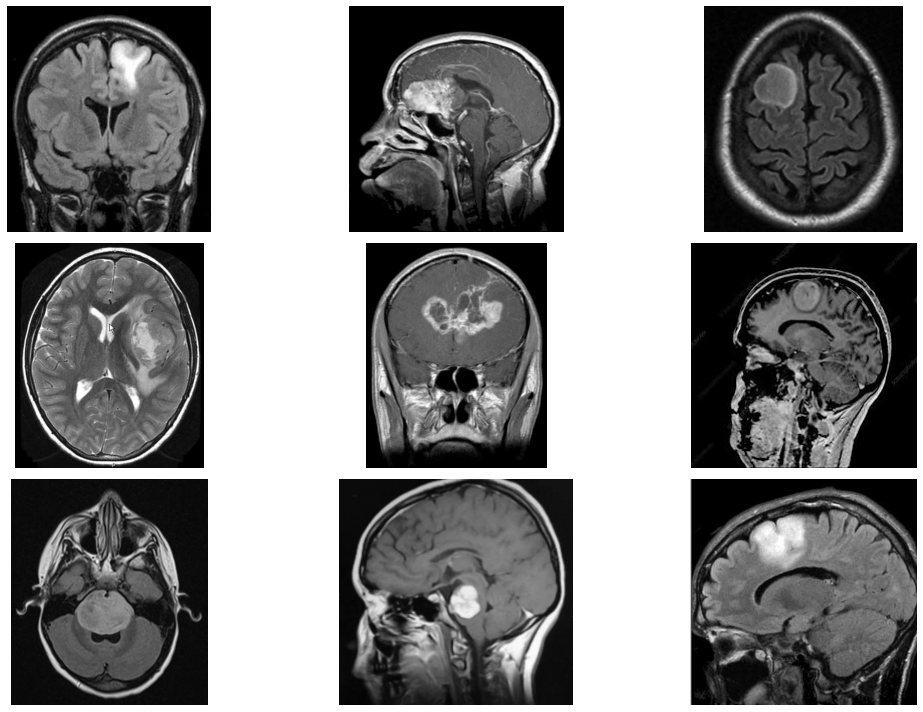

In [ ]:
glioma_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/glioma_tumor'
plot_images(glioma_tumor_dir)

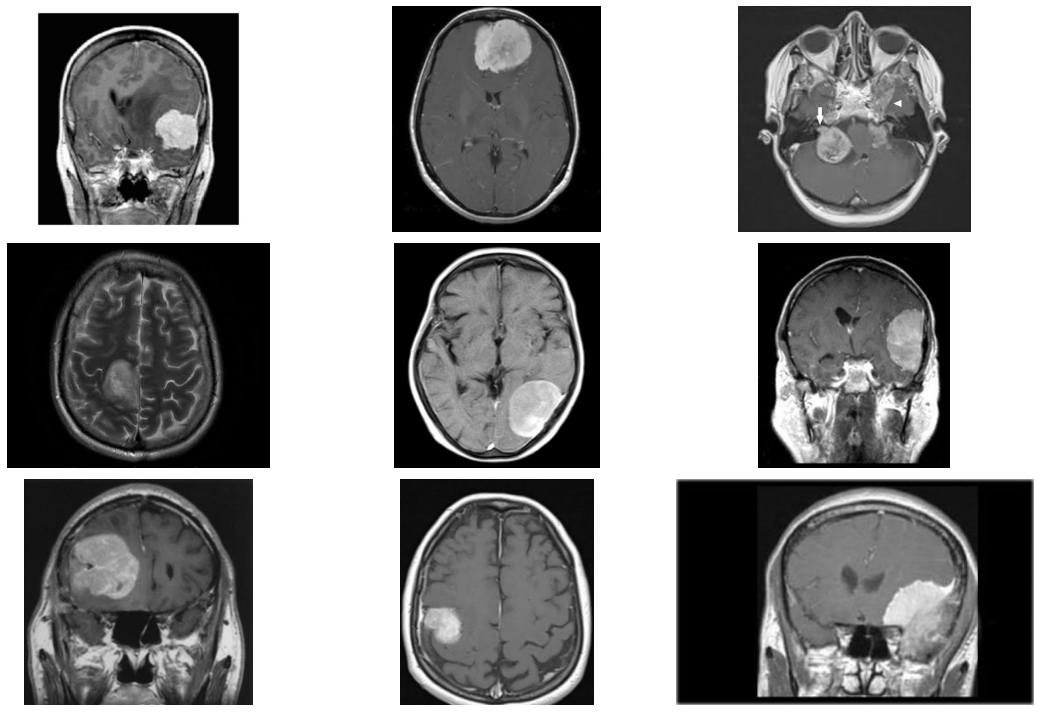

In [ ]:
meningioma_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/meningioma_tumor'
plot_images(meningioma_tumor_dir)

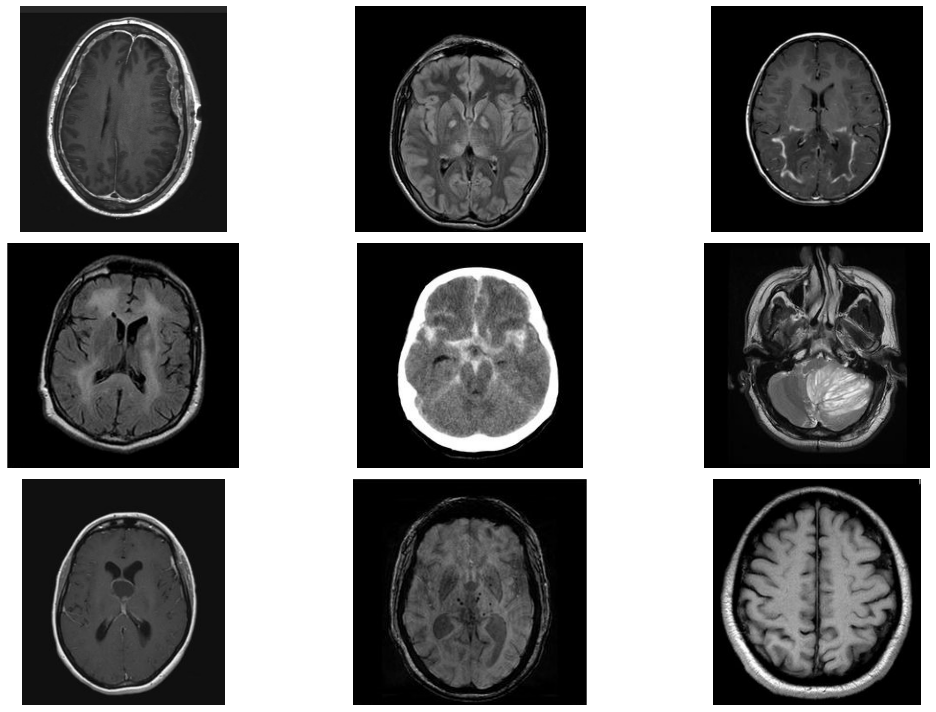

In [ ]:
No_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/no_tumor'
plot_images(No_tumor_dir)

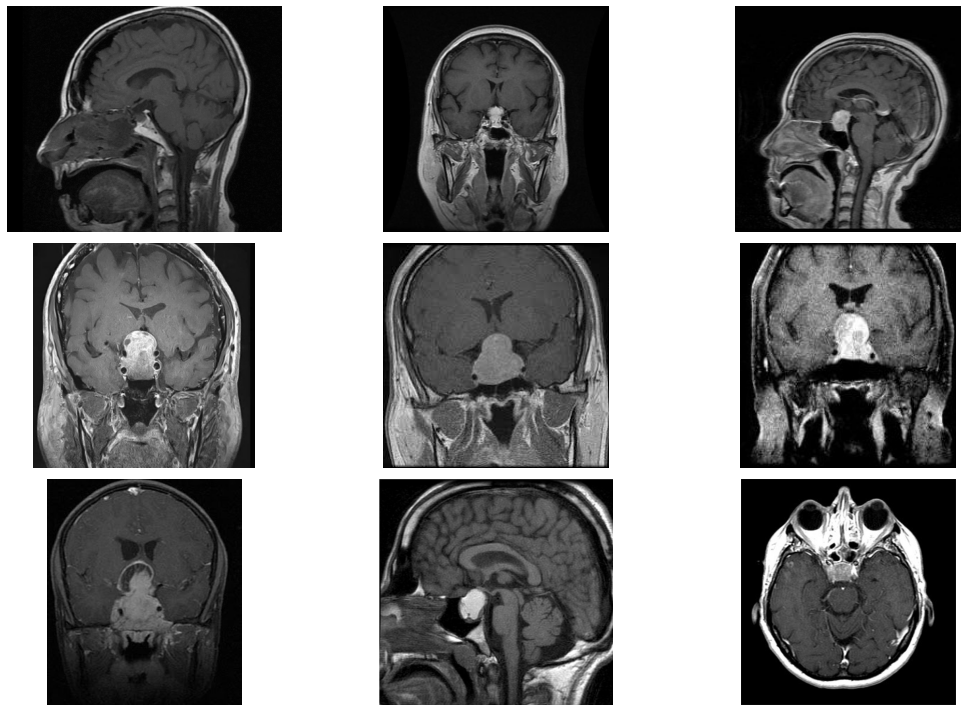

In [ ]:
Pituitary_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/pituitary_tumor'
plot_images(Pituitary_tumor_dir)

In [ ]:
X_train = []
y_train = []
image_size = 150
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Deep Db/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Deep Db/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
y_train

array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', ...,
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [ ]:
classes=["glioma_tumor","pituitary_tumor","meningioma tumor","no tumor"]

In [ ]:
X_train,y_train=shuffle(X_train,y_train,random_state=1)
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
images_dict = dict()
x_train_dict=dict()
for i, l in enumerate(y_train_new):
  if len(images_dict)==4:
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((150, 150,3))
images_dict = dict(sorted(images_dict.items()))
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
x_train_each_class = np.asarray(x_trian_each_class)
    
# example image for each class for test set
X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==4:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [ ]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

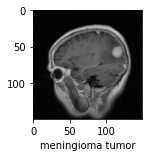

In [ ]:

plot_sample(X_train,y_train_new,0)

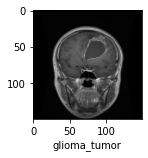

In [ ]:
plot_sample(X_train,y_train_new,6)

# **EfficientNetB7**

In [ ]:
effnet = EfficientNetB7(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9989
Epoch 1: val_accuracy did not improve from 0.97279
83/83 [==============================] - 77s 923ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.1206 - val_accuracy: 0.9728 - lr: 2.4300e-06
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9985
Epoch 2: val_accuracy did not improve from 0.97279
83/83 [==============================] - 77s 922ms/step - loss: 0.0091 - accuracy: 0.9985 - val_loss: 0.1205 - val_accuracy: 0.9728 - lr: 2.4300e-06
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9985
Epoch 3: val_accuracy did not improve from 0.97279

Epoch 3: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
83/83 [==============================] - 76s 915ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.1200 - val_accuracy: 0.9728 - lr: 2.4300e-06
Epoch 4/12
83/83 [=======================

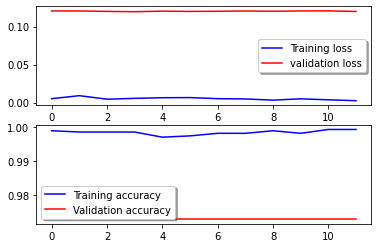

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png") 

predict

In [ ]:
Y_pred=model.predict(X_test)

In [ ]:
Y_pred[:5]

array([[1.2819507e-04, 9.9983454e-01, 1.4264572e-05, 2.2924633e-05],
       [9.9999273e-01, 3.8272046e-06, 3.3722595e-06, 1.4251204e-07],
       [3.1075622e-06, 9.6854246e-06, 5.4856915e-05, 9.9993241e-01],
       [1.2844215e-04, 2.3248489e-03, 1.4165758e-05, 9.9753249e-01],
       [1.1327112e-06, 1.1985883e-07, 2.1043895e-06, 9.9999654e-01]],
      dtype=float32)

In [ ]:
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
y_class[:5]

[1, 0, 3, 3, 3]

In [ ]:
y_test_new[:5]

[1, 0, 3, 3, 3]

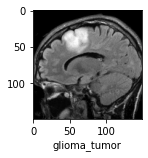

In [ ]:
plot_sample(X_test,y_test_new,5)

In [ ]:
classes[y_class[5]]

'meningioma tumor'

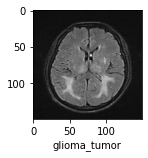

In [ ]:
plot_sample(X_train,y_test_new,1)

In [ ]:
classes[y_class[1]]

'glioma_tumor'

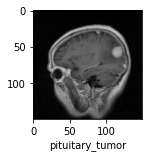

In [ ]:
plot_sample(X_train,y_test_new,0)

In [ ]:
classes[y_class[0]]

'pituitary_tumor'

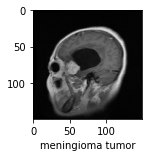

In [ ]:
plot_sample(X_train,y_test_new,11 )

In [ ]:
classes[y_class[11]]

'meningioma tumor'

Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

array([0, 1, 0, 3])

In [ ]:
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 4, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[int(k)]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (classes[k], classes[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()


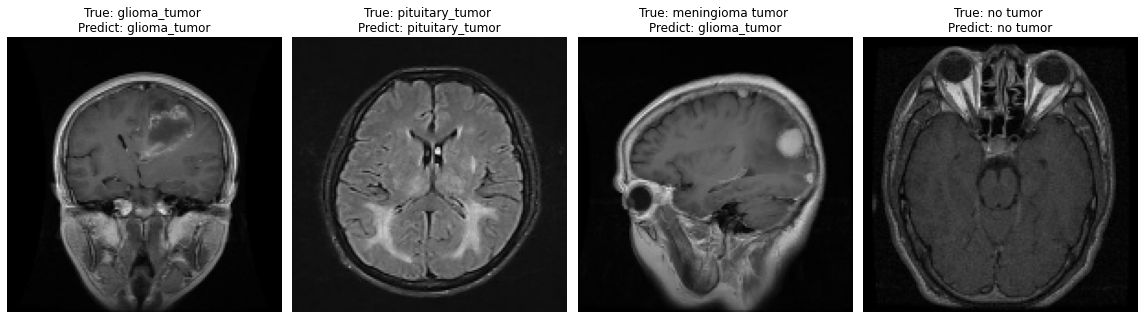

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_actual_predicted(images_dict, predicted_class)
plt.savefig('predited.png',dpi=300)


Shap

S

In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [ ]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [00:53<00:13, 13.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [01:16<00:00, 17.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [01:38, 24.69s/it]


(4, 150, 150, 3, 4)

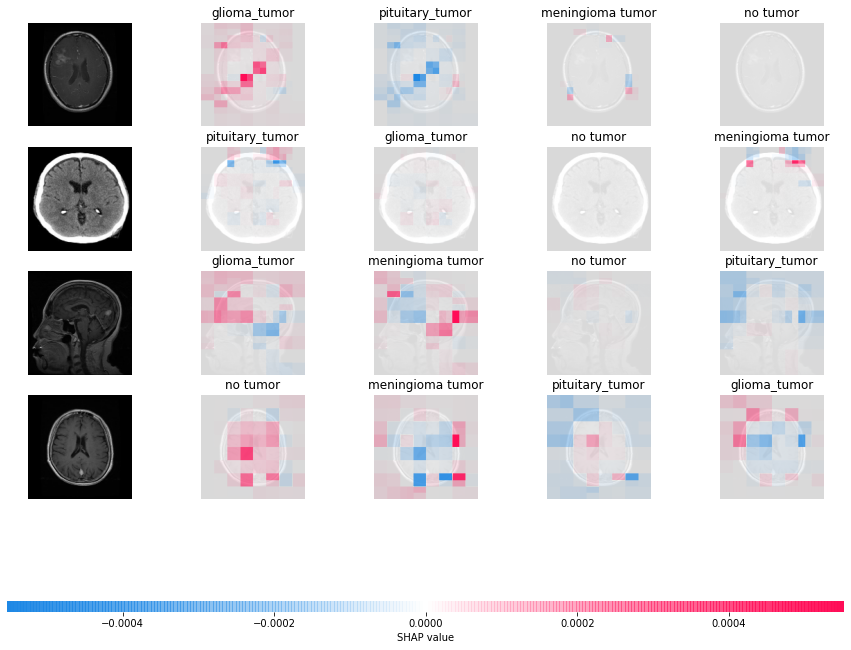

In [ ]:
shap.image_plot(shap_values)

Report,Confution Matrix

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        88
           1       0.98      1.00      0.99        50
           2       0.94      0.97      0.95        96
           3       0.99      0.99      0.99        93

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[82,  1,  5,  0],
       [ 0, 50,  0,  0],
       [ 2,  0, 93,  1],
       [ 0,  0,  1, 92]], dtype=int32)>

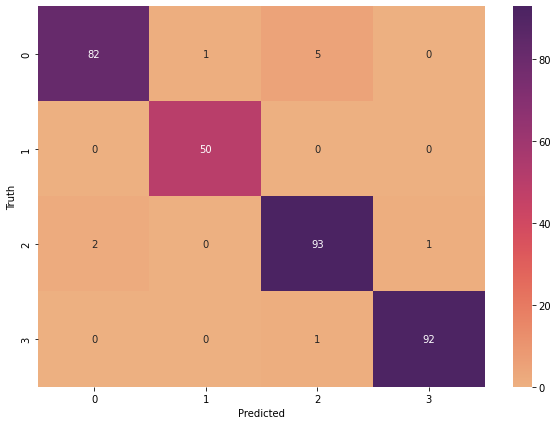

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='flare')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(".png") 


# **vGG16**

In [118]:
vgg=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3)
)
vgg.trainable=False

In [102]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout


In [119]:
model = Sequential()
model.add(vgg)
model.add(Conv2D(filters=512, 
              kernel_size=(3, 3), 
              padding='same', 
              activation='relu', 
              input_shape=(150,150,3), 
              name='conv3_1'))
model.add(Conv2D(filters=512, 
              kernel_size=(3, 3), 
                  padding='same', 
              activation='relu',
              name='conv3_2'))
model.add(Conv2D(filters=512, 
              kernel_size=(3, 3), 
                  padding='same', 
              activation='relu',
              name='conv3_3'))
  
model.add(MaxPooling2D(pool_size=(2,2), 
                   strides=(2,2), 
                   name='max_pooling2d_3'))
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5, name='dropout_4'))
model.add(Dense(4, activation='softmax', name='output'))


In [120]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv3_1 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 conv3_2 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 conv3_3 (Conv2D)            (None, 4, 4, 512)         2359808   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                     

In [121]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [122]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [123]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 2.3188 - accuracy: 0.6962
Epoch 1: val_accuracy improved from -inf to 0.87755, saving model to vgg16.h5
83/83 [==============================] - 10s 102ms/step - loss: 2.3188 - accuracy: 0.6962 - val_loss: 0.4198 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8687
Epoch 2: val_accuracy did not improve from 0.87755
83/83 [==============================] - 8s 101ms/step - loss: 0.3499 - accuracy: 0.8687 - val_loss: 0.4494 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9228
Epoch 3: val_accuracy improved from 0.87755 to 0.88095, saving model to vgg16.h5
83/83 [==============================] - 8s 100ms/step - loss: 0.2300 - accuracy: 0.9228 - val_loss: 0.3802 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.1748 

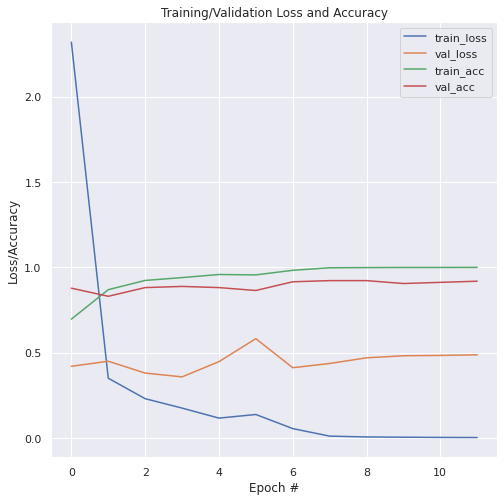

In [125]:
EPOCHS=12
sns.set()
N = np.arange(0, EPOCHS)
plt.figure(figsize=(8,8))
plt.plot(N, model.history.history["loss"], label="train_loss")
plt.plot(N, model.history.history["val_loss"], label="val_loss")
plt.plot(N, model.history.history["accuracy"], label="train_acc")
plt.plot(N, model.history.history["val_accuracy"], label="val_acc")
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


predict


In [ ]:
Y_pred=model.predict(X_test)


In [ ]:
y_class=[np.argmax(x) for x in Y_pred]


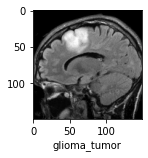

In [ ]:
plot_sample(X_test,y_test_new,5)

In [ ]:
classes[y_class[5]]

'glioma_tumor'

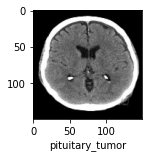

In [ ]:
plot_sample(X_test,y_test_new,0)

Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

array([0, 1, 3, 3])

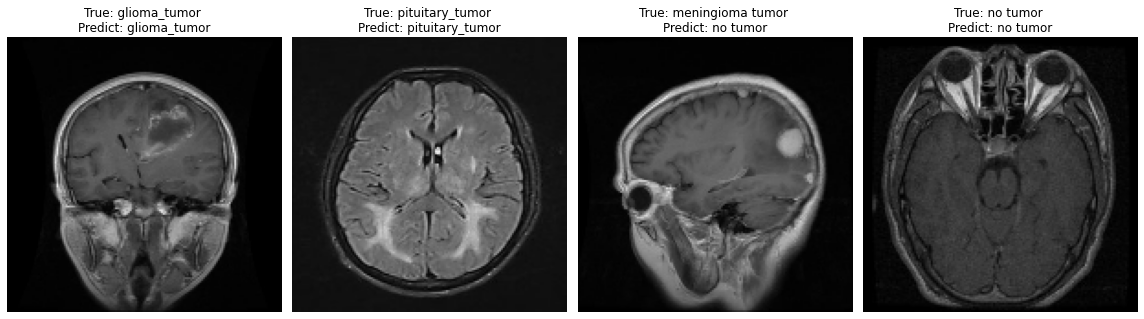

In [ ]:
plot_actual_predicted(images_dict, predicted_class)


In [126]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [127]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [00:24<00:03,  3.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [00:31<00:00,  5.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [00:39,  9.83s/it]


(4, 150, 150, 3, 4)

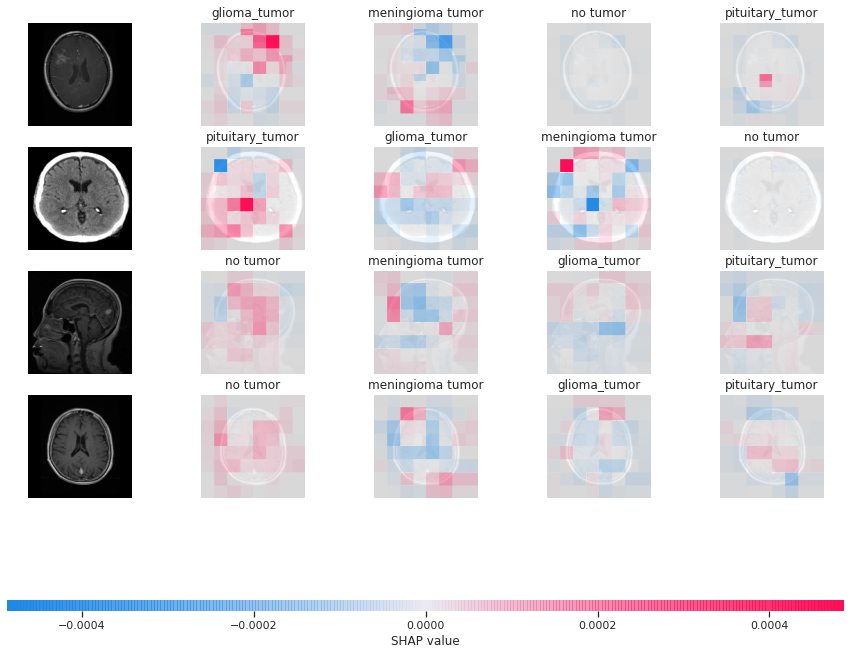

In [128]:
shap.image_plot(shap_values)

In [129]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        88
           1       0.94      0.94      0.94        50
           2       0.88      0.88      0.88        96
           3       0.95      0.96      0.95        93

    accuracy                           0.91       327
   macro avg       0.91      0.91      0.91       327
weighted avg       0.91      0.91      0.91       327



In [130]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[78,  3,  7,  0],
       [ 2, 47,  0,  1],
       [ 8,  0, 84,  4],
       [ 0,  0,  4, 89]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

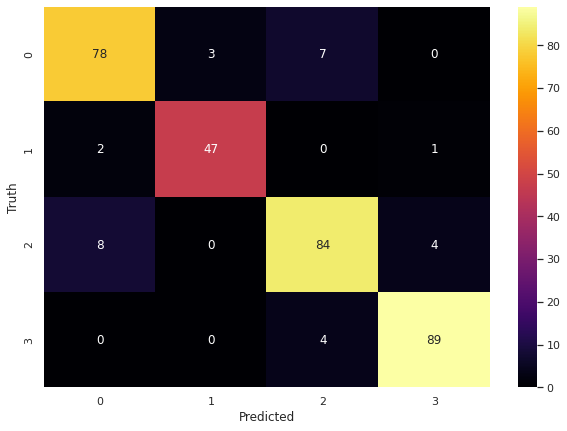

In [131]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='inferno')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [134]:
from lime import lime_image

In [138]:
explainer = lime_image.LimeImageExplainer()

In [141]:
explanation = explainer.explain_instance(X_train[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [142]:
from skimage.segmentation import mark_boundaries

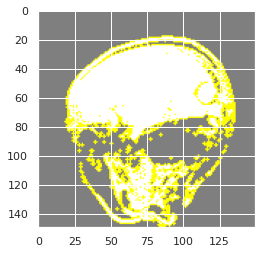

In [143]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

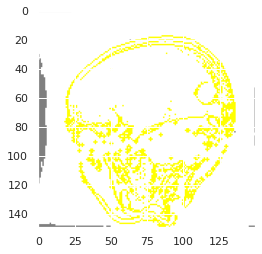

In [144]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

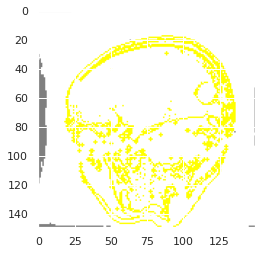

In [145]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

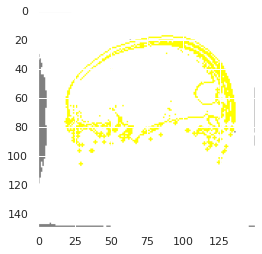

In [146]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

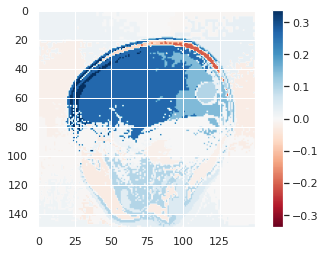

In [147]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# **Resnet50**

In [166]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [167]:
resnet= ResNet50(
    input_shape =(150,150,3), # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

In [169]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [170]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [171]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [172]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [173]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.6916
Epoch 1: val_accuracy improved from -inf to 0.32653, saving model to vgg16.h5
83/83 [==============================] - 26s 216ms/step - loss: 0.9968 - accuracy: 0.6916 - val_loss: 14261.9658 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8593
Epoch 2: val_accuracy did not improve from 0.32653
83/83 [==============================] - 15s 176ms/step - loss: 0.3884 - accuracy: 0.8593 - val_loss: 6.9270 - val_accuracy: 0.2823 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9311
Epoch 3: val_accuracy did not improve from 0.32653

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [==============================] - 14s 175ms/step - loss: 0.2263 - accuracy: 0.9311 - val_loss: 2.9663 - val_accuracy: 0.2925 - lr: 0.0010
Epoch 4/12
83/83 [====

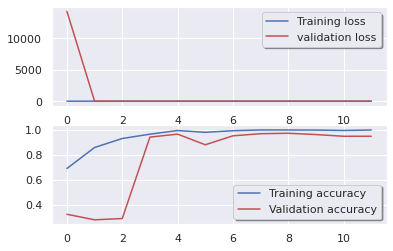

In [175]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png") 

In [176]:
Y_pred=model.predict(X_test)


In [177]:
y_class=[np.argmax(x) for x in Y_pred]


In [178]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        88
           1       0.94      0.98      0.96        50
           2       0.92      0.94      0.93        96
           3       0.97      1.00      0.98        93

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



In [179]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[78,  3,  7,  0],
       [ 0, 49,  1,  0],
       [ 3,  0, 90,  3],
       [ 0,  0,  0, 93]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

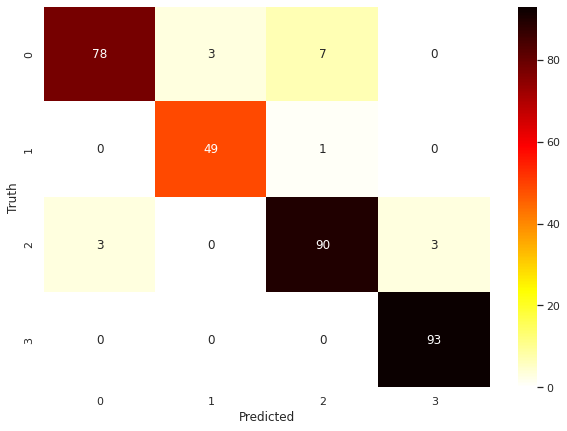

In [188]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='hot_r')
plt.xlabel('Predicted')
plt.ylabel('Truth')